In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pycce as pc
import ase
from ase.build import bulk

from mpl_toolkits import mplot3d

seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

In [21]:
# Generate unitcell from ase
diamond = bulk('C', 'diamond', cubic=True)
diamond = pc.read_ase(diamond)

In [22]:
# Populate Bath cell with isotopes
diamond.add_isotopes(('13C', 0.011))

defaultdict(dict, {'C': {'13C': 0.011}})

In [23]:
# Set z-direction of the bath (defect)
diamond.zdir = [1, 1, 1]

In [24]:
# Generate spin bath
### Add the defect. remove and add atoms at the positions (in cell coordinates)
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]),
                              seed=seed)

# Note, that because the 14C isotope doesn’t have a spin, PyCCE does not find it in common isotopes, and raises a warning. We have to provide SpinType for it separately, or define the properties as follows:
atoms['14C'].gyro = 0
atoms['14C'].spin = 0

In [86]:
# Setting up the Simulator

### Parameters of CCE calculations engine
# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 8  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

##########################################################################################
# ZFS Parametters of NV center in diamond
D = 1.88 * 1e6 # in kHz
E = 0 # in kHz
##########################################################################################

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# The code already knows most exsiting isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

In [87]:
print(nv)

CenterArray
(s: [1.],
xyz:
[[0. 0. 0.]],
zfs:
[[[-626666.66667       0.            0.     ]
  [      0.      -626666.66667       0.     ]
  [      0.            0.      1253333.33333]]],
gyro:
[[[-17608.59705     -0.          -0.     ]
  [    -0.      -17608.59705     -0.     ]
  [    -0.          -0.      -17608.59705]]])


In [88]:
# Setting the Simulator object
### Setting the runner engine
calc = pc.Simulator(spin=nv, bath=atoms, D=D,
                    r_bath=r_bath, r_dipole=r_dipole, order=order)

In [89]:
print(calc)

Simulator for center array of size 1.
magnetic field:
array([0., 0., 0.])

Parameters of cluster expansion:
r_bath: 40
r_dipole: 8
order: 2

Bath consists of 506 spins.

Clusters include:
506  clusters of order 1.
876  clusters of order 2.



In [90]:
# # Taking advantage of subclassing np.ndarray we can change in situ the quadrupole tensor of the Nitrogen nuclear spin.
# nspin = calc.bath
# # Set model quadrupole tensor at N atom
# quad = np.asarray([[-2.5, 0, 0],
#                    [0, -2.5, 0],
#                    [0, 0,  5.0]]) * 1e3 * 2 * np.pi

# nspin['Q'][nspin['N'] == '14N'] = quad

In [91]:
print(calc)

Simulator for center array of size 1.
magnetic field:
array([0., 0., 0.])

Parameters of cluster expansion:
r_bath: 40
r_dipole: 8
order: 2

Bath consists of 506 spins.

Clusters include:
506  clusters of order 1.
876  clusters of order 2.



In [92]:
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1

##########################################################################################
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G
##########################################################################################

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x',np.pi)]
# pulse_sequence += [pc.Pulse('z',np.pi)]
# pulse_sequence += [pc.Pulse('y',np.pi)]


# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

In [93]:
# calc.compute(time_space, magnetic_field=b,
#              pulses=pulse_sequence,
#              method='gcce',
#              quantity='coherence')


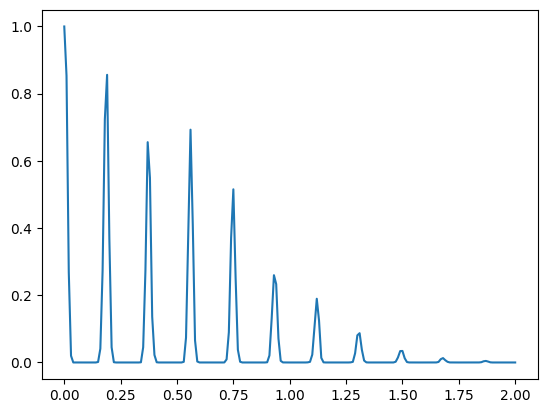

In [94]:
plt.plot(time_space,l_generatilze)